In [ ]:
import pandas as pd
from collections import Counter
from PIL import Image, ImageDraw
import pandas as pd
import IPython.display as display
import os
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import img_to_array, load_img

#### In this code, a CNN-based object localization model is employed to track a specific object in a video. Instead of performing object detection, the focus is solely on implementing localization to identify a single bounding box in the image.

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
ls -r

vl_tpfp.m  vl_argparse.m  sample.mp4   output_video.avi   example_evaluation.m  content/
vl_roc.m   train.csv      README.md    output_video1.avi  evaluation.m          checkpoints/
vl_pr.m    test/          README.html  model.h5           data/                 Boeing767.mp4


In [ ]:
cd /content/drive/MyDrive/fgvc-aircraft-2013b/fgvc-aircraft-2013b/

/content/drive/MyDrive/fgvc-aircraft-2013b/fgvc-aircraft-2013b


In [ ]:

data = pd.read_csv('train.csv')

In [ ]:
data.head()

filename  Classes  Labels
0  1025794.jpg  707-320       0
1  1340192.jpg  707-320       0
2  0056978.jpg  707-320       0
3  0698580.jpg  707-320       0
4  0450014.jpg  707-320       0

In [ ]:
class_counts = Counter(data['Classes'])

classes_to_merge = {class_name for class_name, count in class_counts.items() if '-' in class_name and count > 1}

def determine_merged_class(class_name):
    if class_name in classes_to_merge:
        return class_name.split('-')[0]
    return class_name

data['Family'] = data['Classes'].apply(determine_merged_class)

print(data.head())

      filename  Classes  Labels Family
0  1025794.jpg  707-320       0    707
1  1340192.jpg  707-320       0    707
2  0056978.jpg  707-320       0    707
3  0698580.jpg  707-320       0    707
4  0450014.jpg  707-320       0    707


In [ ]:
# Define column names
columns = ['imageid',  'xmin', 'ymin', 'xmax', 'ymax']
# Read the data into a DataFrame
bounding_boxes= pd.read_csv('data/images_box.txt', delimiter=' ', names=columns)

bounding_boxes['imageid'] = bounding_boxes['imageid'].astype(str) + '.jpg'

# Display the DataFrame
bounding_boxes.head()

imageid  xmin  ymin  xmax  ymax
0  1025794.jpg     3   144   998   431
1   481847.jpg    73   220  1198   508
2  1514522.jpg     7   217  1196   551
3  1340192.jpg    83   155   964   462
4   810608.jpg    19   146   986   443

In [ ]:
traget_family=['A380','767', '747', 'CRJ', '737']
train_data = data[data['Family'].isin(['A380', '767', '747', 'CRJ', '737'])]

In [ ]:
train_data.tail(10)

filename  Classes  Labels Family
1557  1861594.jpg  CRJ-900      46    CRJ
1558  1275811.jpg  CRJ-900      46    CRJ
1559  1113449.jpg  CRJ-900      46    CRJ
1560  1517329.jpg  CRJ-900      46    CRJ
1561  2221719.jpg  CRJ-900      46    CRJ
1562  1781328.jpg  CRJ-900      46    CRJ
1563  2117313.jpg  CRJ-900      46    CRJ
1564  1348827.jpg  CRJ-900      46    CRJ
1565  1342007.jpg  CRJ-900      46    CRJ
1566  1929102.jpg  CRJ-900      46    CRJ

In [ ]:

train_data = pd.merge(bounding_boxes, train_data, how='inner', left_on='imageid', right_on='filename')

# Drop the redundant column (filename)
train_data.drop(columns=['filename'], inplace=True)

In [ ]:
train_data.head()

imageid  xmin  ymin  xmax  ymax  Classes  Labels Family
0  1152739.jpg    65   125  1152   560  737-200       2    737
1  1187709.jpg    10   186  1017   534  737-200       2    737
2  1548405.jpg    14   178  1488   720  737-200       2    737
3  1094669.jpg   118   157  1015   478  737-200       2    737
4  1189268.jpg    39   173   996   515  737-200       2    737

In [ ]:
df = train_data
family_mapping = {'737': 0, '747': 1, '767': 2, 'A380': 3, 'CRJ': 4}

# Apply the mapping to the 'Family' column
df['Target'] = df['Family'].map(family_mapping)

In [ ]:
# df.to_csv('flight_filtered.csv')

In [ ]:
unique_families = df['Family'].unique()

# Initialize an empty DataFrame to store the results
result_df = pd.DataFrame(columns=df.columns)

# Loop through each unique family and select the first record
for family in unique_families:
    first_record = df[df['Family'] == family].iloc[2]  # Select the first record for each family
    result_df = result_df.append(first_record)  # Append the first record to the result DataFrame

# Reset the index of the result DataFrame
result_df = result_df.reset_index(drop=True)

<ipython-input-39-82a9924511e7>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(first_record)  # Append the first record to the result DataFrame
<ipython-input-39-82a9924511e7>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(first_record)  # Append the first record to the result DataFrame
<ipython-input-39-82a9924511e7>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(first_record)  # Append the first record to the result DataFrame
<ipython-input-39-82a9924511e7>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(first_rec

In [ ]:
result_df

imageid xmin ymin  xmax ymax  Classes Labels Family Target
0  1152739.jpg   65  125  1152  560  737-200      2    737      0
1  1008872.jpg   29  157  1006  447  747-100     10    747      1
2  1605155.jpg   32  134  1017  474  767-200     16    767      2
3  2194956.jpg   30  147  1005  472     A380     33   A380      3
4  2184006.jpg   37  240  1058  478  CRJ-200     44    CRJ      4

image shape (1500, 1012)


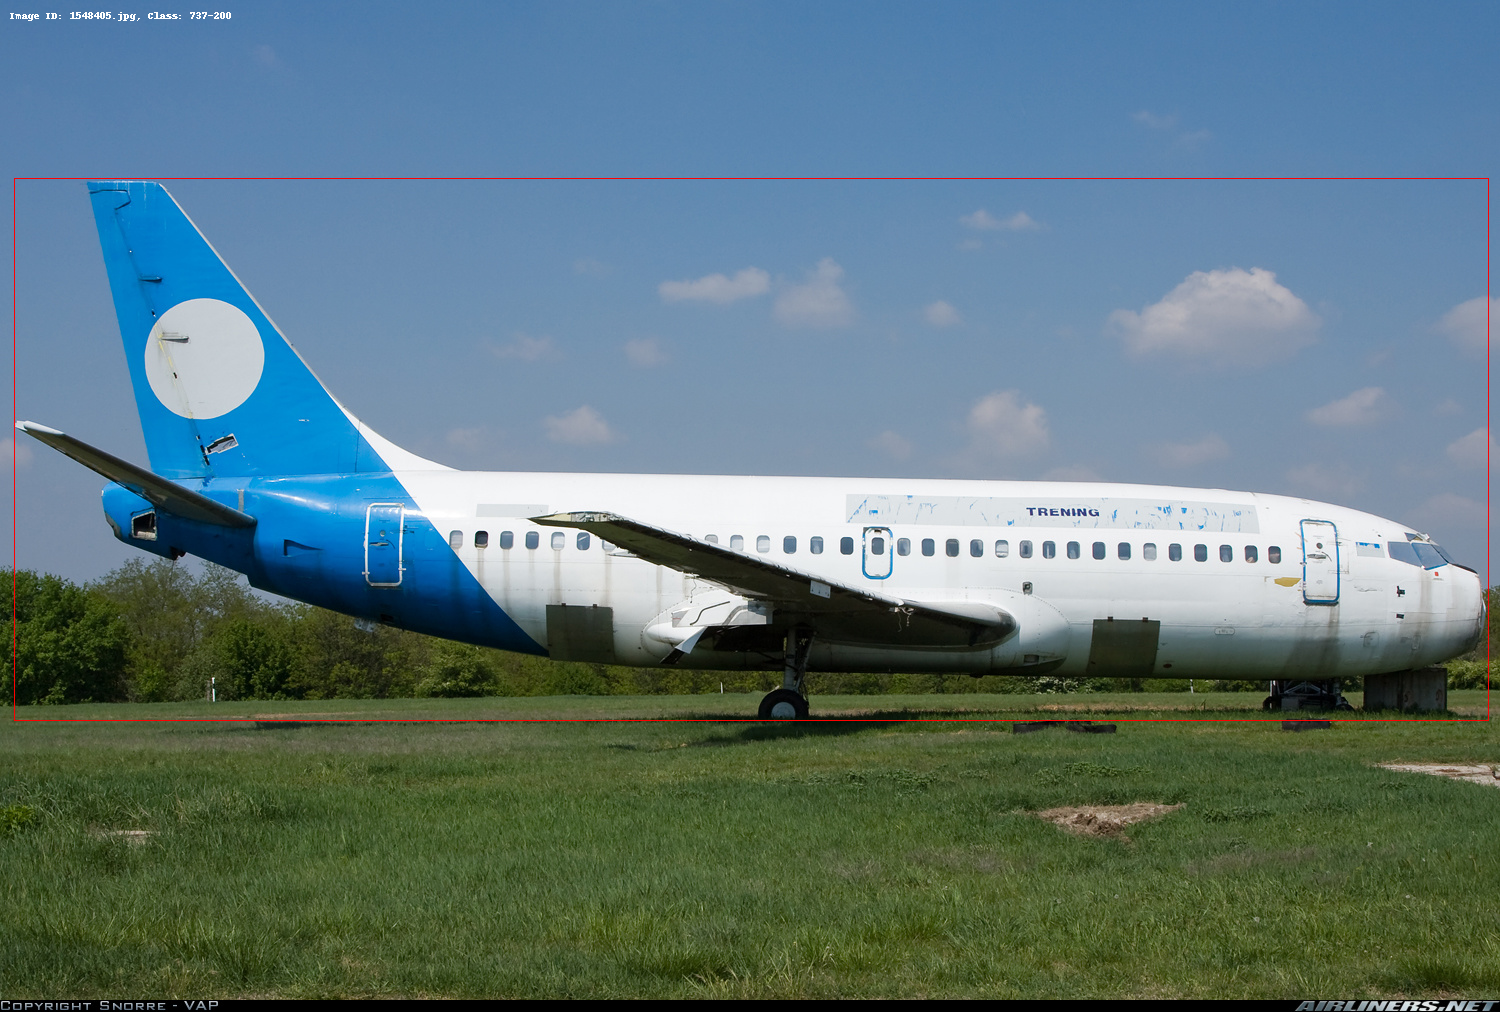

image shape (1200, 805)


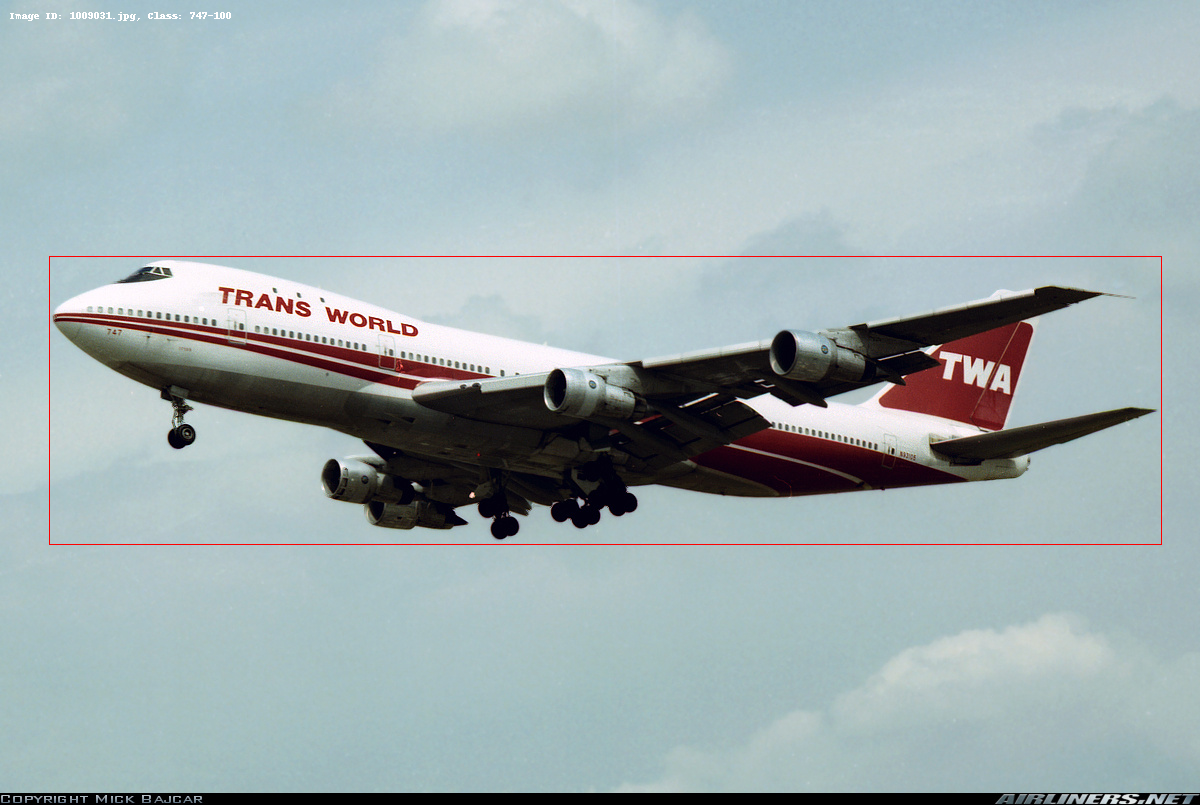

image shape (1200, 812)


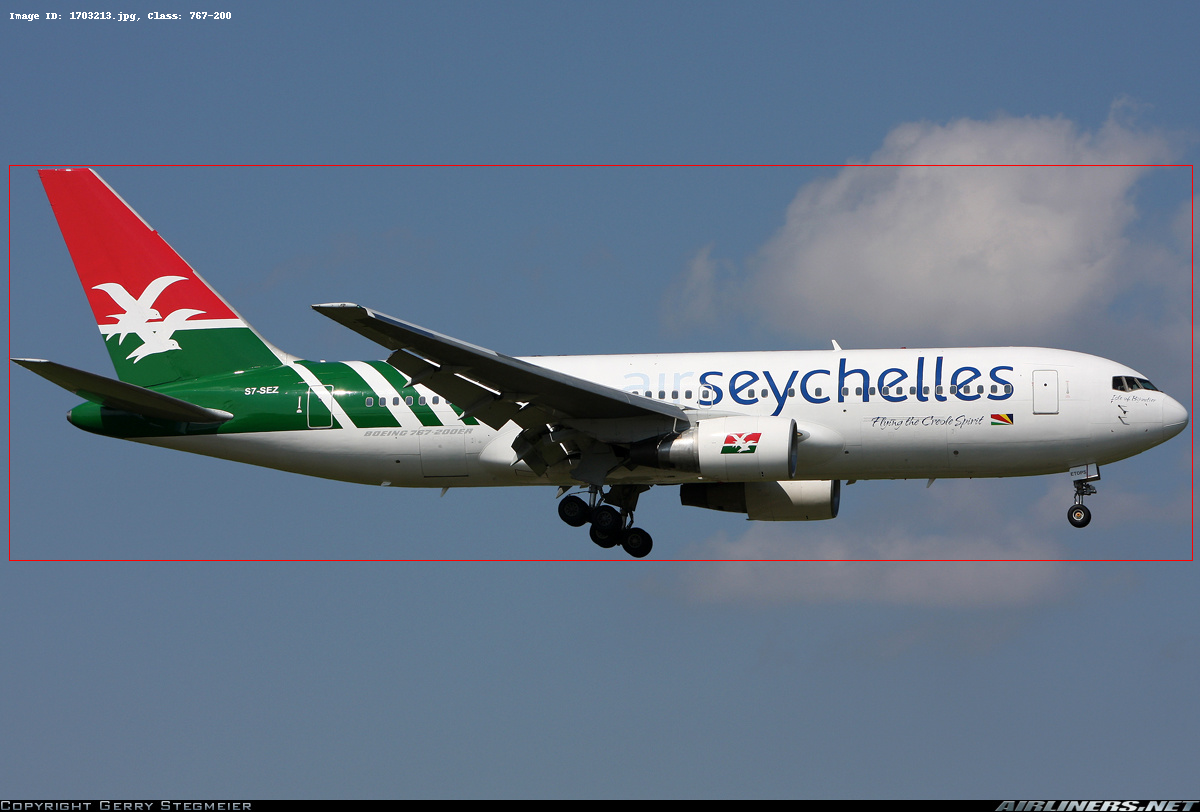

image shape (1200, 812)


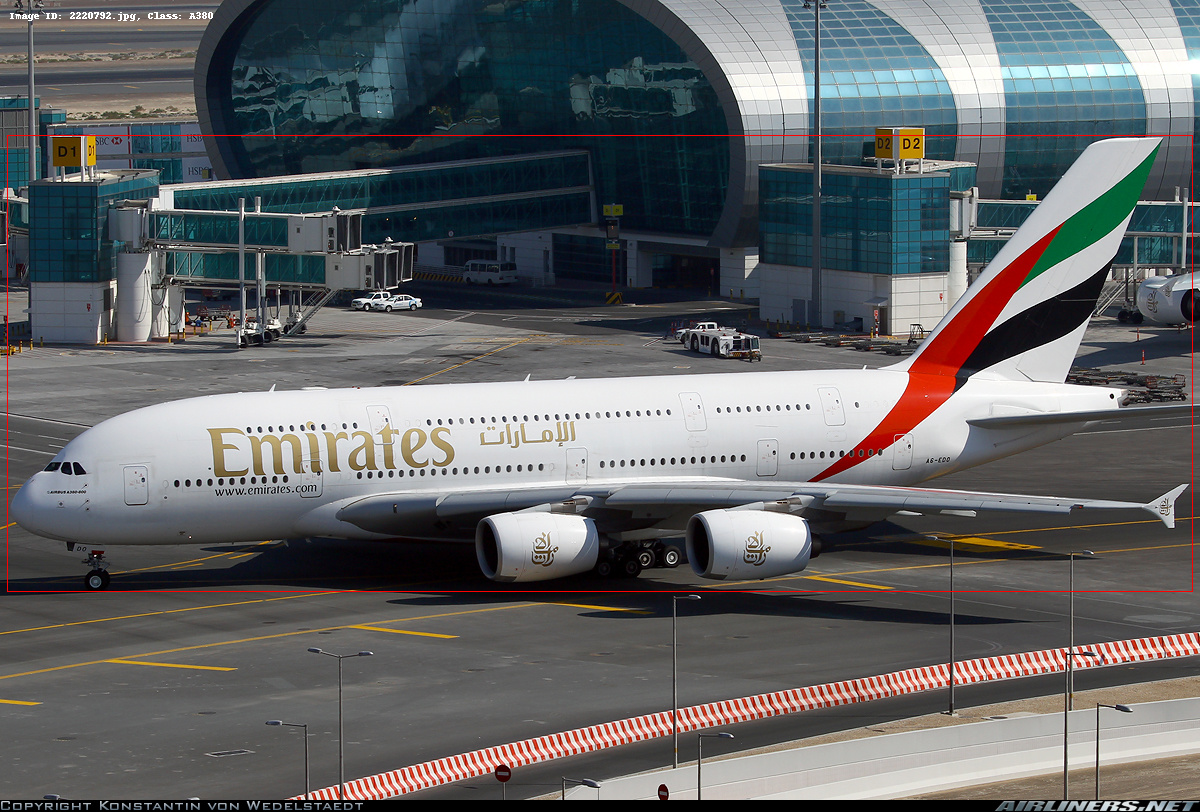

image shape (1024, 710)


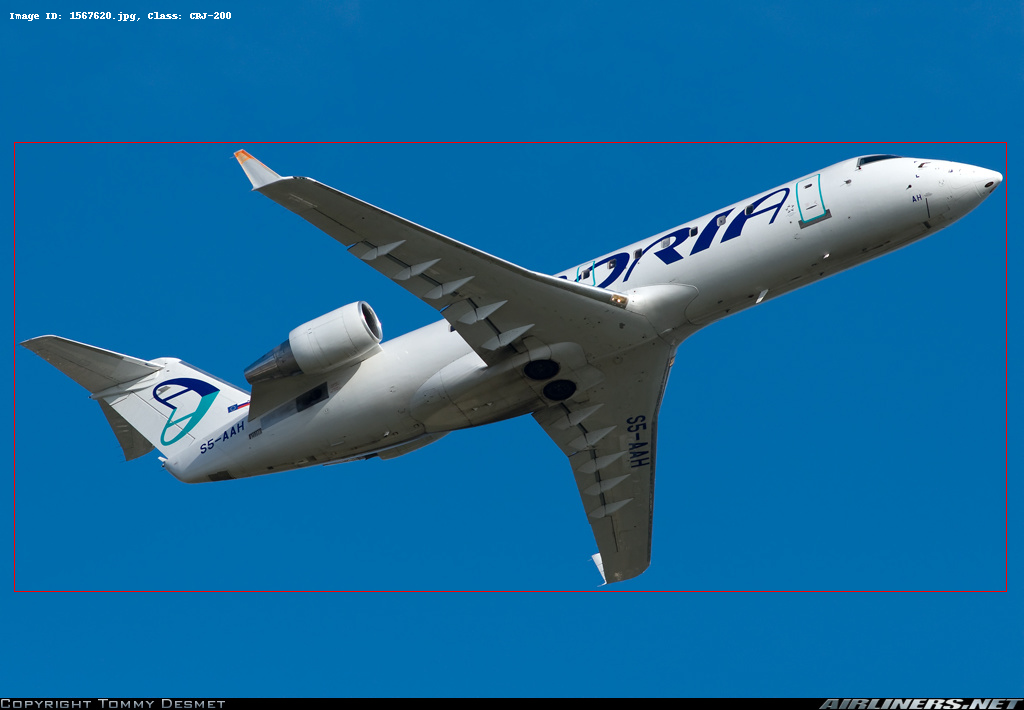

In [ ]:

path_image='data/images/'

# Function to draw bounding boxes on images and add title
def draw_boxes(image_path, boxes, title):
    image = Image.open(image_path)
    print(f"image shape {image.size}")
    draw = ImageDraw.Draw(image)
    for box in boxes:
        xmin, ymin, xmax, ymax = box
        draw.rectangle([xmin, ymin, xmax, ymax], outline="red")
    draw.text((10, 10), title, fill="white")  # Add title at position (10, 10)
    return image

# Iterate over each row in the DataFrame and draw bounding boxes on the corresponding images
for index, row in result_df.iterrows():
    image_path = path_image + row['imageid']  # Update this path with the location of your images
    boxes = [(row['xmin'], row['ymin'], row['xmax'], row['ymax'])]
    title = f"Image ID: {row['imageid']}, Class: {row['Classes']}"  # Title for the image
    result_image = draw_boxes(image_path, boxes, title)
    display.display(result_image)  # Display the image with bounding box and title


In [ ]:
# # Define the model
# def create_model(input_shape, num_classes):
#     input_layer = layers.Input(shape=input_shape)
#     conv1 = layers.Conv2D(32, (3, 3), activation='relu')(input_layer)
#     pool1 = layers.MaxPooling2D((2, 2))(conv1)
#     conv2 = layers.Conv2D(64, (3, 3), activation='relu')(pool1)
#     pool2 = layers.MaxPooling2D((2, 2))(conv2)
#     conv3 = layers.Conv2D(64, (3, 3), activation='relu')(pool2)
#     flat = layers.Flatten()(conv3)

#     # Localization output branch
#     localization_dense1 = layers.Dense(64, activation='relu')(flat)
#     bbox_output = layers.Dense(4, name='bbox_output')(localization_dense1)  # Output for bounding box coordinates

#     # Classification output branch
#     classification_dense1 = layers.Dense(64, activation='relu')(flat)
#     classification_output = layers.Dense(num_classes, activation='softmax', name='classification_output')(classification_dense1)

#     model = keras.Model(inputs=input_layer, outputs=[bbox_output, classification_output])
#     return model

In [ ]:
from tensorflow.keras import layers, models

def create_model(input_shape, num_classes):
    input_layer = layers.Input(shape=input_shape)
    conv1 = layers.Conv2D(32, (3, 3), activation='relu')(input_layer)
    pool1 = layers.MaxPooling2D((2, 2))(conv1)

    conv2 = layers.Conv2D(64, (3, 3), activation='relu')(pool1)
    pool2 = layers.MaxPooling2D((2, 2))(conv2)

    conv3 = layers.Conv2D(128, (3, 3), activation='relu')(pool2)
    pool3 = layers.MaxPooling2D((2, 2))(conv3)

    conv4 = layers.Conv2D(256, (3, 3), activation='relu')(pool3)
    pool4 = layers.MaxPooling2D((2, 2))(conv4)

    conv5 = layers.Conv2D(512, (3, 3), activation='relu')(pool4)
    pool5 = layers.MaxPooling2D((2, 2))(conv5)

    flatten = layers.Flatten()(pool5)

    # Localization output branch
    localization_dense1 = layers.Dense(256, activation='relu')(flatten)
    bbox_output = layers.Dense(4, name='bbox_output')(localization_dense1)  # Output for bounding box coordinates

    # Classification output branch
    classification_dense1 = layers.Dense(256, activation='relu')(flatten)
    classification_output = layers.Dense(num_classes, activation='softmax', name='classification_output')(classification_dense1)

    model = models.Model(inputs=input_layer, outputs=[bbox_output, classification_output])


    return model


In [ ]:

def generate_data(images_paths, top_lefts, bottom_rights, labels, input_shape, num_classes):
    images = []
    bbox_labels = []
    classification_labels = []

    for img_path, top_left, bottom_right, label in zip(images_paths, top_lefts, bottom_rights, labels):
        # Load and preprocess image
        img = load_img(img_path, target_size=(input_shape[0], input_shape[1]))
        img_array = img_to_array(img) / 255.0  # Normalize
        images.append(img_array)


        x1, y1 = top_left
        x2, y2 = bottom_right

        bbox_label = [x1, y1, x2, y2]
        bbox_labels.append(bbox_label)

        # Classification labels
        classification_labels.append(label)

    return np.array(images), [np.array(bbox_labels), np.array(classification_labels)]


In [ ]:
# Define input shape and create model
input_shape = (128, 128, 3)  # example input shape
num_classes = 5  # example number of classes
model = create_model(input_shape, num_classes)
model.compile(optimizer='adam', loss={'bbox_output': 'mse', 'classification_output': 'sparse_categorical_crossentropy'}, loss_weights={'bbox_output': 1.0, 'classification_output': 1.0})



In [ ]:
df.head(2)

imageid  xmin  ymin  xmax  ymax  Classes  Labels Family  Target
0  1152739.jpg    65   125  1152   560  737-200       2    737       0
1  1187709.jpg    10   186  1017   534  737-200       2    737       0

In [ ]:
# from sklearn.model_selection import train_test_split

# # Split the dataset into train and test sets with stratified sampling
# df, test_data = train_test_split(df, test_size=0.5, stratify=df['Target'])



In [ ]:
df.Target.value_counts()

1    70
5    34
2    33
3    31
4    17
Name: Target, dtype: int64

In [ ]:
# # Example images paths, bounding box coordinates, and labels
# images_paths = [path_image+i for i in df['imageid'].tolist()[:recodes_train]]  # Replace with actual image paths
# top_lefts = [(x, y) for x, y in zip(df.xmin.tolist()[:recodes_train],df.ymin.tolist()[:recodes_train])]

# bottom_rights = [(x, y) for x, y in zip(df.xmax.tolist()[:recodes_train],df.ymax.tolist()[:recodes_train])]
#     # Example bottom-right coordinates
# labels_target = df.Target.tolist()[:recodes_train] # Example labels, replace with actual labels



In [ ]:
# Example images paths, bounding box coordinates, and labels
images_paths = [path_image+i for i in df['imageid'].tolist()]  # Replace with actual image paths
top_lefts = [(x, y) for x, y in zip(df.xmin.tolist(),df.ymin.tolist())]

bottom_rights = [(x, y) for x, y in zip(df.xmax.tolist(),df.ymax.tolist())]
    # Example bottom-right coordinates
labels_target = df.Target.tolist() # Example labels, replace with actual labels



In [ ]:
f"{len(images_paths)},{len(top_lefts)},{len(bottom_rights)},{len(labels_target)}"

'370,370,370,370'

In [ ]:
# Generate training data
images, labels = generate_data(images_paths, top_lefts, bottom_rights, labels_target, input_shape, num_classes)

In [ ]:
# Define the directory where you want to save the model
checkpoint_dir = '/content/drive/MyDrive/fgvc-aircraft-2013b/fgvc-aircraft-2013b'

# Create the directory if it doesn't exist
os.makedirs(checkpoint_dir, exist_ok=True)

# Define the file path to save the model
model_path = os.path.join(checkpoint_dir, 'best_model.h5')

In [ ]:
ls

Boeing767.mp4        data/                 model.h5           README.md   vl_argparse.m
Boeing767_video.avi  evaluation.m          output_video1.avi  sample.mp4  vl_pr.m
checkpoints/         example_evaluation.m  output_video.avi   test/       vl_roc.m
content/             flight_filtered.csv   README.html        train.csv   vl_tpfp.m


In [ ]:
# Define checkpoint callback

checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath=model_path,
                                                      monitor='val_classification_output_accuracy',
                                                      mode='max',
                                                      save_best_only=True)

# Train the model
history = model.fit(images, labels, epochs=3, batch_size=32, validation_split=0.2, callbacks=[checkpoint_callback])

# # Plot training and validation accuracy
# plt.plot(history.history['classification_output_accuracy'], label='Training Accuracy')
# plt.plot(history.history['val_classification_output_accuracy'], label='Validation Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()

Epoch 1/3
10/10 [==============================] - ETA: 0s - loss: 287435.9062 - bbox_output_loss: 287420.3125 - classification_output_loss: 15.6385

10/10 [==============================] - 15s 1s/step - loss: 287435.9062 - bbox_output_loss: 287420.3125 - classification_output_loss: 15.6385 - val_loss: 17605.9590 - val_bbox_output_loss: 17308.0000 - val_classification_output_loss: 297.9619
Epoch 2/3
10/10 [==============================] - ETA: 0s - loss: 67228.0859 - bbox_output_loss: 67215.1484 - classification_output_loss: 12.9338

10/10 [==============================] - 12s 1s/step - loss: 67228.0859 - bbox_output_loss: 67215.1484 - classification_output_loss: 12.9338 - val_loss: 59715.8438 - val_bbox_output_loss: 59348.6562 - val_classification_output_loss: 367.1933
Epoch 3/3
10/10 [==============================] - ETA: 0s - loss: 35236.9375 - bbox_output_loss: 35225.5664 - classification_output_loss: 11.3739

10/10 [==============================] - 12s 1s/step - loss: 35236.9375 - bbox_output_loss: 35225.5664 - classification_output_loss: 11.3739 - val_loss: 29996.0176 - val_bbox_output_loss: 29765.1621 - val_classification_output_loss: 230.8542


In [ ]:
model = tf.keras.models.load_model('model.h5')

# Now you can use this loaded model for inference
# For example, you can make predictions on new data like this:
# predictions = best_model.predict(new_data)

In [ ]:
# Import EarlyStopping callback
from tensorflow.keras.callbacks import EarlyStopping

# Define EarlyStopping callback
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with EarlyStopping callback
history = model.fit(images, labels, epochs=50, batch_size=32, validation_split=0.2, callbacks=[checkpoint_callback, early_stopping_callback])

Epoch 1/50
10/10 [==============================] - ETA: 0s - loss: 21031.1094 - bbox_output_loss: 21011.9199 - classification_output_loss: 19.1903

10/10 [==============================] - 12s 1s/step - loss: 21031.1094 - bbox_output_loss: 21011.9199 - classification_output_loss: 19.1903 - val_loss: 15549.3613 - val_bbox_output_loss: 15321.8633 - val_classification_output_loss: 227.4965
Epoch 2/50
10/10 [==============================] - ETA: 0s - loss: 15276.5859 - bbox_output_loss: 15253.2588 - classification_output_loss: 23.3263

10/10 [==============================] - 12s 1s/step - loss: 15276.5859 - bbox_output_loss: 15253.2588 - classification_output_loss: 23.3263 - val_loss: 16808.0156 - val_bbox_output_loss: 16586.7520 - val_classification_output_loss: 221.2639
Epoch 3/50
10/10 [==============================] - ETA: 0s - loss: 10761.2266 - bbox_output_loss: 10734.4844 - classification_output_loss: 26.7414

10/10 [==============================] - 12s 1s/step - loss: 10761.2266 - bbox_output_loss: 10734.4844 - classification_output_loss: 26.7414 - val_loss: 14216.9492 - val_bbox_output_loss: 14015.5088 - val_classification_output_loss: 201.4397
Epoch 4/50
10/10 [==============================] - ETA: 0s - loss: 10511.6885 - bbox_output_loss: 10501.7158 - classification_output_loss: 9.9722

10/10 [==============================] - 10s 1s/step - loss: 10511.6885 - bbox_output_loss: 10501.7158 - classification_output_loss: 9.9722 - val_loss: 13271.8037 - val_bbox_output_loss: 13087.1602 - val_classification_output_loss: 184.6438
Epoch 5/50
10/10 [==============================] - ETA: 0s - loss: 10256.9336 - bbox_output_loss: 10243.3018 - classification_output_loss: 13.6310

10/10 [==============================] - 12s 1s/step - loss: 10256.9336 - bbox_output_loss: 10243.3018 - classification_output_loss: 13.6310 - val_loss: 12936.4854 - val_bbox_output_loss: 12747.9658 - val_classification_output_loss: 188.5187
Epoch 6/50
10/10 [==============================] - ETA: 0s - loss: 10538.9375 - bbox_output_loss: 10530.2539 - classification_output_loss: 8.6834

10/10 [==============================] - 12s 1s/step - loss: 10538.9375 - bbox_output_loss: 10530.2539 - classification_output_loss: 8.6834 - val_loss: 13297.5654 - val_bbox_output_loss: 13123.7432 - val_classification_output_loss: 173.8222
Epoch 7/50
10/10 [==============================] - ETA: 0s - loss: 10661.0732 - bbox_output_loss: 10654.0781 - classification_output_loss: 6.9957

10/10 [==============================] - 12s 1s/step - loss: 10661.0732 - bbox_output_loss: 10654.0781 - classification_output_loss: 6.9957 - val_loss: 12983.6416 - val_bbox_output_loss: 12812.8145 - val_classification_output_loss: 170.8273
Epoch 8/50
10/10 [==============================] - ETA: 0s - loss: 10383.8369 - bbox_output_loss: 10375.7041 - classification_output_loss: 8.1329

10/10 [==============================] - 12s 1s/step - loss: 10383.8369 - bbox_output_loss: 10375.7041 - classification_output_loss: 8.1329 - val_loss: 13060.2520 - val_bbox_output_loss: 12890.6367 - val_classification_output_loss: 169.6157
Epoch 9/50
10/10 [==============================] - ETA: 0s - loss: 10288.0215 - bbox_output_loss: 10280.8408 - classification_output_loss: 7.1815

10/10 [==============================] - 12s 1s/step - loss: 10288.0215 - bbox_output_loss: 10280.8408 - classification_output_loss: 7.1815 - val_loss: 12595.6445 - val_bbox_output_loss: 12428.0576 - val_classification_output_loss: 167.5869
Epoch 10/50
10/10 [==============================] - ETA: 0s - loss: 10277.5771 - bbox_output_loss: 10271.4717 - classification_output_loss: 6.1049

10/10 [==============================] - 11s 1s/step - loss: 10277.5771 - bbox_output_loss: 10271.4717 - classification_output_loss: 6.1049 - val_loss: 13021.5332 - val_bbox_output_loss: 12842.7432 - val_classification_output_loss: 178.7886
Epoch 11/50
10/10 [==============================] - ETA: 0s - loss: 10195.7344 - bbox_output_loss: 10191.3564 - classification_output_loss: 4.3777

10/10 [==============================] - 11s 1s/step - loss: 10195.7344 - bbox_output_loss: 10191.3564 - classification_output_loss: 4.3777 - val_loss: 12364.2793 - val_bbox_output_loss: 12200.3789 - val_classification_output_loss: 163.9006
Epoch 12/50
10/10 [==============================] - ETA: 0s - loss: 11223.4297 - bbox_output_loss: 11218.6611 - classification_output_loss: 4.7672

10/10 [==============================] - 12s 1s/step - loss: 11223.4297 - bbox_output_loss: 11218.6611 - classification_output_loss: 4.7672 - val_loss: 13856.0518 - val_bbox_output_loss: 13686.3789 - val_classification_output_loss: 169.6721
Epoch 13/50
10/10 [==============================] - ETA: 0s - loss: 10198.8193 - bbox_output_loss: 10194.8965 - classification_output_loss: 3.9221

10/10 [==============================] - 12s 1s/step - loss: 10198.8193 - bbox_output_loss: 10194.8965 - classification_output_loss: 3.9221 - val_loss: 12264.6230 - val_bbox_output_loss: 12106.1816 - val_classification_output_loss: 158.4423
Epoch 14/50
10/10 [==============================] - ETA: 0s - loss: 10422.4131 - bbox_output_loss: 10418.1748 - classification_output_loss: 4.2364

10/10 [==============================] - 12s 1s/step - loss: 10422.4131 - bbox_output_loss: 10418.1748 - classification_output_loss: 4.2364 - val_loss: 12682.1211 - val_bbox_output_loss: 12526.2520 - val_classification_output_loss: 155.8699
Epoch 15/50
10/10 [==============================] - ETA: 0s - loss: 10180.6221 - bbox_output_loss: 10176.3643 - classification_output_loss: 4.2586

10/10 [==============================] - 12s 1s/step - loss: 10180.6221 - bbox_output_loss: 10176.3643 - classification_output_loss: 4.2586 - val_loss: 12016.2070 - val_bbox_output_loss: 11858.1152 - val_classification_output_loss: 158.0916
Epoch 16/50
10/10 [==============================] - ETA: 0s - loss: 11716.2422 - bbox_output_loss: 11709.9385 - classification_output_loss: 6.3040

10/10 [==============================] - 12s 1s/step - loss: 11716.2422 - bbox_output_loss: 11709.9385 - classification_output_loss: 6.3040 - val_loss: 12710.7188 - val_bbox_output_loss: 12544.2891 - val_classification_output_loss: 166.4301
Epoch 17/50
10/10 [==============================] - ETA: 0s - loss: 11048.1221 - bbox_output_loss: 11040.3818 - classification_output_loss: 7.7405

10/10 [==============================] - 11s 1s/step - loss: 11048.1221 - bbox_output_loss: 11040.3818 - classification_output_loss: 7.7405 - val_loss: 12048.2168 - val_bbox_output_loss: 11888.5439 - val_classification_output_loss: 159.6722
Epoch 18/50
10/10 [==============================] - ETA: 0s - loss: 10553.4600 - bbox_output_loss: 10548.7930 - classification_output_loss: 4.6671

10/10 [==============================] - 12s 1s/step - loss: 10553.4600 - bbox_output_loss: 10548.7930 - classification_output_loss: 4.6671 - val_loss: 14609.0029 - val_bbox_output_loss: 14466.9795 - val_classification_output_loss: 142.0238
Epoch 19/50
10/10 [==============================] - ETA: 0s - loss: 10710.0645 - bbox_output_loss: 10705.2930 - classification_output_loss: 4.7711

10/10 [==============================] - 12s 1s/step - loss: 10710.0645 - bbox_output_loss: 10705.2930 - classification_output_loss: 4.7711 - val_loss: 12581.9443 - val_bbox_output_loss: 12442.3018 - val_classification_output_loss: 139.6423
Epoch 20/50
10/10 [==============================] - ETA: 0s - loss: 9922.3779 - bbox_output_loss: 9917.0449 - classification_output_loss: 5.3334

10/10 [==============================] - 12s 1s/step - loss: 9922.3779 - bbox_output_loss: 9917.0449 - classification_output_loss: 5.3334 - val_loss: 13445.0469 - val_bbox_output_loss: 13295.6465 - val_classification_output_loss: 149.4002


In [ ]:
# # Generate training data
# images, labels = generate_data(images_paths, top_lefts, bottom_rights, labels, input_shape, num_classes)

# Train the model
model.fit(images, labels, epochs=30, batch_size=50)

Epoch 1/30
8/8 [==============================] - 15s 2s/step - loss: 326060.8125 - bbox_output_loss: 326055.9062 - classification_output_loss: 4.9374
Epoch 2/30
8/8 [==============================] - 13s 2s/step - loss: 69413.1016 - bbox_output_loss: 69375.3203 - classification_output_loss: 37.7868
Epoch 3/30
8/8 [==============================] - 13s 2s/step - loss: 29414.7656 - bbox_output_loss: 29395.4512 - classification_output_loss: 19.3151
Epoch 4/30
8/8 [==============================] - 13s 2s/step - loss: 21714.4141 - bbox_output_loss: 21703.3320 - classification_output_loss: 11.0825
Epoch 5/30
8/8 [==============================] - 14s 2s/step - loss: 14307.9189 - bbox_output_loss: 14295.9707 - classification_output_loss: 11.9481
Epoch 6/30
8/8 [==============================] - 14s 2s/step - loss: 13648.0039 - bbox_output_loss: 13641.3086 - classification_output_loss: 6.6972
Epoch 7/30
8/8 [==============================] - 13s 2s/step - loss: 11887.2158 - bbox_output_loss:

#### saving the model for the inference

In [ ]:
model.save('model_updated.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:

ls

Boeing767.mp4        data/                 model.h5           README.html  train.csv      vl_tpfp.m
Boeing767_video.avi  evaluation.m          model_updated.h5   README.md    vl_argparse.m
checkpoints/         example_evaluation.m  output_video1.avi  sample.mp4   vl_pr.m
content/             flight_filtered.csv   output_video.avi   test/        vl_roc.m


In [ ]:
input_shape[0]

128

In [ ]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Load and preprocess the image
image_path =images_paths[10]  # Replace with the path to your image
img = load_img(image_path, target_size=(input_shape[0], input_shape[1]))
img_array = img_to_array(img) / 255.0  # Normalize

# Reshape the image to add batch dimension
img_array = np.expand_dims(img_array, axis=0)

# Predict using the model
bbox_predictions, classification_predictions = model.predict(img_array)

# Print the predictions
print("Bounding box predictions:")
print(bbox_predictions)

print("Classification predictions:")
print(classification_predictions)


1/1 [==============================] - 0s 34ms/step
Bounding box predictions:
[[  11.264628  180.07567  1168.3816    541.7224  ]]
Classification predictions:
[[4.4926438e-03 5.3183612e-07 9.9550641e-01 3.4275303e-07 0.0000000e+00]]


In [ ]:
f"{top_lefts[10]}, {bottom_rights[10]}, {labels_target[10]}"

'(7, 233), (1187, 515), 4'

In [ ]:
bbox_predictions, classification_predictions = model.predict(images_paths[1])

# Print the predictions
print("Bounding box predictions:")
print(bbox_predictions)
print("Classification predictions:")
print(classification_predictions)

IndexError: tuple index out of range

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Load the trained model
model = tf.keras.models.load_model('model_updated.h5')  # Replace with your model file path

# Function to perform object detection and classification on a frame
def detect_and_classify_objects(frame):
    # Preprocess the frame
    resized_frame = cv2.resize(frame, (128, 128))  # Resize to model's input shape
    resized_frame = resized_frame / 255.0  # Normalize
    resized_frame = np.expand_dims(resized_frame, axis=0)  # Add batch dimension

    # Perform object detection and classification
    bbox_predictions, classification_predictions = model.predict(resized_frame)
    bbox_predictions = bbox_predictions[0]  # Remove batch dimension
    classification_predictions = classification_predictions[0]  # Remove batch dimension

    return bbox_predictions, classification_predictions

# Function to draw bounding boxes and labels on the frame
def draw_bbox_and_labels(frame, bbox_predictions, classification_predictions):
    # Draw bounding boxes

    x, y, width, height = [int(round(val)) for val in bbox_predictions]
    cv2.rectangle(frame, (x, y), ( width, height), (0, 255, 0), 2)

    # Draw class labels
    for i, class_prob in enumerate(classification_predictions):
        class_label = np.argmax(class_prob)
        class_name = str(class_label)  # Replace with your class names
        # x, y = int(bbox_predictions[i][0]), int(bbox_predictions[i][1])
        cv2.putText(frame, class_name, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    return frame




In [ ]:
from tensorflow.keras.models import load_model

# Load the model from the H5 file
model = load_model('model_updated.h5')

# Print the summary of the model
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 126, 126, 32)         896       ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)           0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 61, 61, 64)           18496     ['max_pooling2d[0][0]']   

In [ ]:
ls

shell-init: error retrieving current directory: getcwd: cannot access parent directories: Transport endpoint is not connected
ls: cannot open directory '.': Transport endpoint is not connected


#### object tracking based on the saved model and saving the updated video

In [ ]:
# Open the video file
video_path = 'Boeing767.mp4'  # Replace with your video file path
# {'737': 0, '747': 1, '767': 2, 'A380': 3, 'CRJ': 4}
cap = cv2.VideoCapture(video_path)

# print(cap)

# Get video properties
fps = cap.get(cv2.CAP_PROP_FPS)
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Define the codec and create VideoWriter object to save the processed video
out = cv2.VideoWriter('Boeing767_video.avi', cv2.VideoWriter_fourcc(*'DIVX'), fps, (frame_width, frame_height))

# Process each frame in the video
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Perform object detection and classification
    bbox_predictions, classification_predictions = detect_and_classify_objects(frame)

    # Draw bounding boxes and labels on the frame
    frame_with_bbox_and_labels = draw_bbox_and_labels(frame, bbox_predictions, classification_predictions)

    # Write the processed frame to the output video
    out.write(frame_with_bbox_and_labels)

    # Display the frame
    # cv2.imshow('Frame', frame_with_bbox_and_labels)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video capture and video writer objects
cap.release()
out.release()

# Close all OpenCV windows
cv2.destroyAllWindows()


1/1 [==============================] - 0s 32ms/step


*italicized text*